In [2]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import matplotlib.patches as mpatches

# Modeling & metrics

from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [3]:
sls = pd.read_csv("../data/sales.csv", parse_dates=["date"])
sls.set_index("date", inplace=True)
sls = sls.sort_index()
sls = sls.asfreq("D")  # set daily frequency (adjust if your data is not daily)

# Exogenous features
use_exog = {'promo', 'is_holiday'}.issubset(sls.columns)
exog = sls[['promo', 'is_holiday']].astype(int) if use_exog else None

# Handle missing values in the target (simple, robust choice)
if sls['sales'].isna().sum() > 0:
    sls['sales'] = sls['sales'].interpolate('time')

print(
    "Rows:", len(sls),
    "| Start:", sls.index.min().date(),
    "| End:", sls.index.max().date(),
    "| Freq:", sls.index.freq
)
print("Use exogenous features:", use_exog)
print("Use exog:", use_exog)

Rows: 731 | Start: 2023-01-01 | End: 2024-12-31 | Freq: <Day>
Use exogenous features: True
Use exog: True


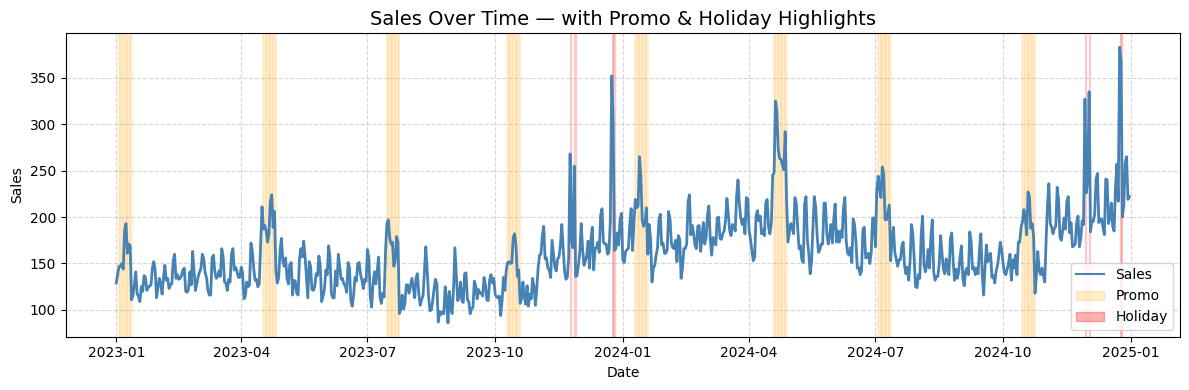

In [4]:
plt.figure(figsize=(12,4))
plt.plot(sls.index, sls['sales'], label='Sales', color='steelblue', linewidth=2)

for date in sls[sls['promo'] == 1].index:
    plt.axvspan(date, date + pd.Timedelta(days=1), color='orange', alpha=0.1)

for date in sls[sls['is_holiday'] == 1].index:
    plt.axvspan(date, date + pd.Timedelta(days=1), color='red', alpha=0.15)

promo_patch = mpatches.Patch(color='orange', alpha=0.2, label='Promo')
holiday_patch = mpatches.Patch(color='red', alpha=0.3, label='Holiday')

plt.legend(handles=[
    plt.Line2D([], [], color='steelblue', label='Sales'),
    promo_patch, 
    holiday_patch
])

plt.title("Sales Over Time — with Promo & Holiday Highlights", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Sales")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


In [5]:
# Train/Test split + simple baselines
y = sls['sales']
h = 30  # length of holdout (e.g., last 30 days)

train, test = y.iloc[:-h], y.iloc[-h:]
train_x = exog.iloc[:-h] if use_exog else None
test_x  = exog.iloc[-h:]  if use_exog else None

# Baseline 1: Naive (tomorrow = today)
naive_pred = pd.Series(train.iloc[-1], index=test.index)
naive_rmse = mean_squared_error(test, naive_pred)**0.5
naive_mae  = mean_absolute_error(test, naive_pred)

# Baseline 2: Seasonal-Naive (repeat last week; assumes weekly seasonality m=7)
m = 7
seasonal_naive = y.shift(m).iloc[-h:]
sn_rmse = mean_squared_error(test, seasonal_naive)**0.5
sn_mae  = mean_absolute_error(test, seasonal_naive)

print(f"Naive          RMSE/MAE: {naive_rmse:.2f} / {naive_mae:.2f}")
print(f"Seasonal-Naive RMSE/MAE: {sn_rmse:.2f} / {sn_mae:.2f}")

Naive          RMSE/MAE: 51.96 / 40.40
Seasonal-Naive RMSE/MAE: 70.72 / 38.77


In [6]:
# One solid model: SARIMA(2,1,1) x (1,1,1,7)
# - (p,d,q) = (2,1,1) from ACF/PACF intuition
# - seasonal order (P,D,Q,m) = (1,1,1,7) for weekly seasonality
order = (2,1,1)
seasonal_order = (1,1,1,7)

model = SARIMAX(
    train,
    order=order,
    seasonal_order=seasonal_order,
    exog=train_x, # pass None if you prefer to ignore exogenous features
    enforce_stationarity=False,
    enforce_invertibility=False
)
res = model.fit(disp=False)

# Forecast over the holdout horizon
fc = res.get_forecast(steps=h, exog=test_x)
yhat = fc.predicted_mean
conf = fc.conf_int()

# Safe index alignment (avoids edge-case mismatches)
y_true, y_pred = test.align(yhat, join="inner")
rmse = mean_squared_error(y_true, y_pred)**0.5
mae  = mean_absolute_error(y_true, y_pred)
mape = (np.abs((y_true - y_pred) / np.clip(y_true, 1e-9, None))).mean() * 100

print(f"SARIMA{order}x{seasonal_order}  RMSE/MAE/MAPE: {rmse:.2f} / {mae:.2f} / {mape:.1f}%")

SARIMA(2, 1, 1)x(1, 1, 1, 7)  RMSE/MAE/MAPE: 19.48 / 14.56 / 5.9%


c:\Users\dmitr\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


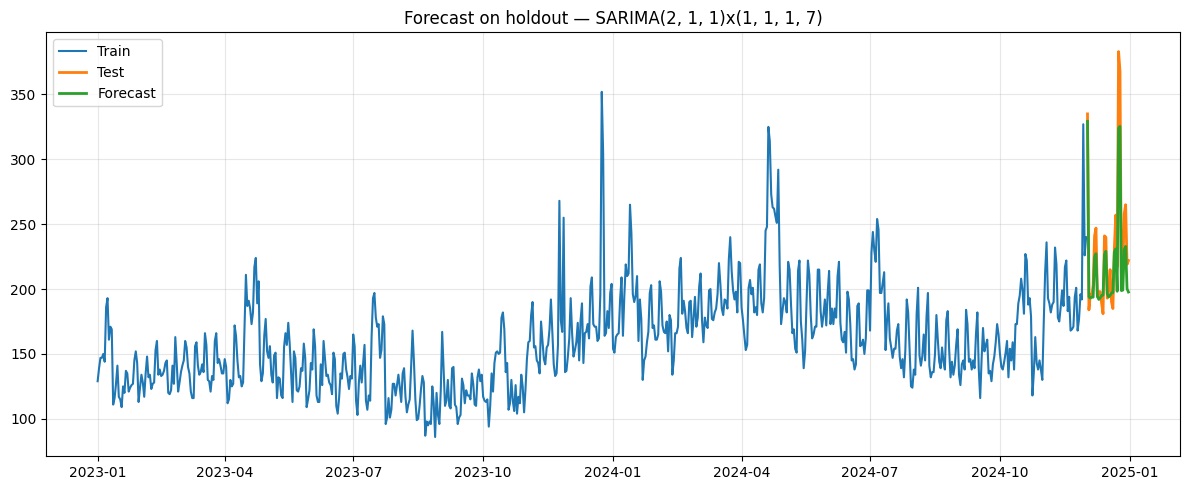

In [7]:
# Visualize Train / Test / Forecast
plt.figure(figsize=(12,5))
plt.plot(train.index, train, label="Train")
plt.plot(test.index,  test,  label="Test",  linewidth=2)
plt.plot(yhat.index,  yhat,  label="Forecast", linewidth=2)
# Show confidence intervals:
# plt.fill_between(conf.index, conf.iloc[:,0], conf.iloc[:,1], alpha=0.2, label="95% CI")
plt.title(f"Forecast on holdout — SARIMA{order}x{seasonal_order}")
plt.legend(); plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()

In [8]:
# Quick verdict vs. baselines
def verdict_line(name, r, a):
    return f"{name:<15s} | RMSE={r:6.2f}  MAE={a:6.2f}"

print(verdict_line("Naive", naive_rmse, naive_mae))
print(verdict_line("Seasonal-Naive", sn_rmse, sn_mae))
print(verdict_line("SARIMA", rmse, mae))

better_than_sn = (rmse < sn_rmse) and (mae < sn_mae)
print("\nConclusion: SARIMA better Seasonal-Naive?" , "Yes" if better_than_sn else "No")


Naive           | RMSE= 51.96  MAE= 40.40
Seasonal-Naive  | RMSE= 70.72  MAE= 38.77
SARIMA          | RMSE= 19.48  MAE= 14.56

Conclusion: SARIMA better Seasonal-Naive? Yes
